<a href="https://colab.research.google.com/github/jordantab/11785-assignment-part2s/blob/main/HW2P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

# Libraries

In [1]:
!nvidia-smi # Run this to see what GPU you have

Sun Oct 20 21:35:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              51W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [16]:
!pip install wandb --quiet # Install WandB
!pip install pytorch_metric_learning --quiet #Install the Pytorch Metric Library
!pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'

  Cloning https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup to /tmp/pip-req-build-jl1dg_t1
  Running command git clone --filter=blob:none --quiet https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup /tmp/pip-req-build-jl1dg_t1
  Resolved https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup to commit 12d03c07553aedd3d9e9155e2b3e31ce8c64081a
  Preparing metadata (setup.py) ... done
  Created wheel for cosine_annealing_warmup: filename=cosine_annealing_warmup-2.0-py3-none-any.whl size=4167 sha256=e24e34288e9a251526b8cd302244322ae17244556c0b94154fa3679f289fc3be
  Stored in directory: /tmp/pip-ephem-wheel-cache-cjot6_vg/wheels/29/26/10/bf1a07417dd54aa73bdf09ce4f31c187974a444a1cedddbd99
Successfully built cosine_annealing_warmup


In [17]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
from pytorch_metric_learning import losses
import csv
from torchvision.transforms import v2
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [4]:
from google.colab import drive # Link to your drive if you are not using Colab with GCP
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

Mounted at /content/drive


# Kaggle

In [5]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"jordantab","key":"6012317c8cbe2756d1bf461f146b1d6e"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73248 sha256=026db9b9221a456d15bb649ff1973596668b7624b50490c472db918a08c49050
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [6]:
# # Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/content/data'

!kaggle competitions download -c 11785-hw-2-p-2-face-verification-fall-2024
!unzip -qo '11785-hw-2-p-2-face-verification-fall-2024.zip' -d '/content/data'

100% 2.74G/2.75G [00:12<00:00, 307MB/s]
100% 2.75G/2.75G [00:12<00:00, 244MB/s]


# Config

In [7]:
run_name = "resnet50-cutmix-1"

checkpoint_dir = f"/content/drive/My Drive/hw2p2/checkpoints/{run_name}"
os.makedirs(checkpoint_dir, exist_ok=True)

config = {
    'batch_size': 216, # Increase this if your GPU can handle it
    'p': 0.5,
    'brightness': 0.1,
    'contrast': 0.1,
    'saturation': 0.1,
    'hue': 0.05,
    'lr':  0.1,
    'epochs': 30, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'data_dir': "data/11-785-f24-hw2p2-verification/cls_data",
    'data_ver_dir': "data/11-785-f24-hw2p2-verification/ver_data",
    'checkpoint_dir': checkpoint_dir,
    'run_name': run_name
    # Include other parameters as needed.
}

In [ ]:
print(os.path.exists('data/11-785-f24-hw2p2-verification'))

True


# Dataset

## Dataset Class for doing Image Verification

In [8]:
class ImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2, match = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2), int(match)

In [9]:
class TestImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2 = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2)

## Create Dataloaders for Image Recognition

In [10]:
data_dir = config['data_dir']
# train_dir = os.path.join(data_dir)

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'dev')

# train transforms
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112), # Why are we resizing the Image?
    torchvision.transforms.RandomHorizontalFlip(p=config['p']),
    torchvision.transforms.ColorJitter(brightness=config['brightness'], contrast=config['contrast'], saturation=config['saturation'], hue=config['hue']),
    torchvision.transforms.RandAugment(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                      std=[0.5, 0.5, 0.5])])

# val transforms
val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                      std=[0.5, 0.5, 0.5])])


# get datasets
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=config["batch_size"],
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=8,
                                            sampler=None)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=False,
                                          num_workers=4)

In [11]:
data_dir = config['data_ver_dir']

# get datasets

# TODO: Add your validation pair txt file
pair_dataset = ImagePairDataset(data_dir, csv_file='data/11-785-f24-hw2p2-verification/val_pairs.txt', transform=val_transforms)
pair_dataloader = torch.utils.data.DataLoader(pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# TODO: Add your validation pair txt file
test_pair_dataset = TestImagePairDataset(data_dir, csv_file='data/11-785-f24-hw2p2-verification/test_pairs.txt', transform=val_transforms)
test_pair_dataloader = torch.utils.data.DataLoader(test_pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# EDA and Viz

In [12]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  216
Train batches        :  1998
Val batches          :  200


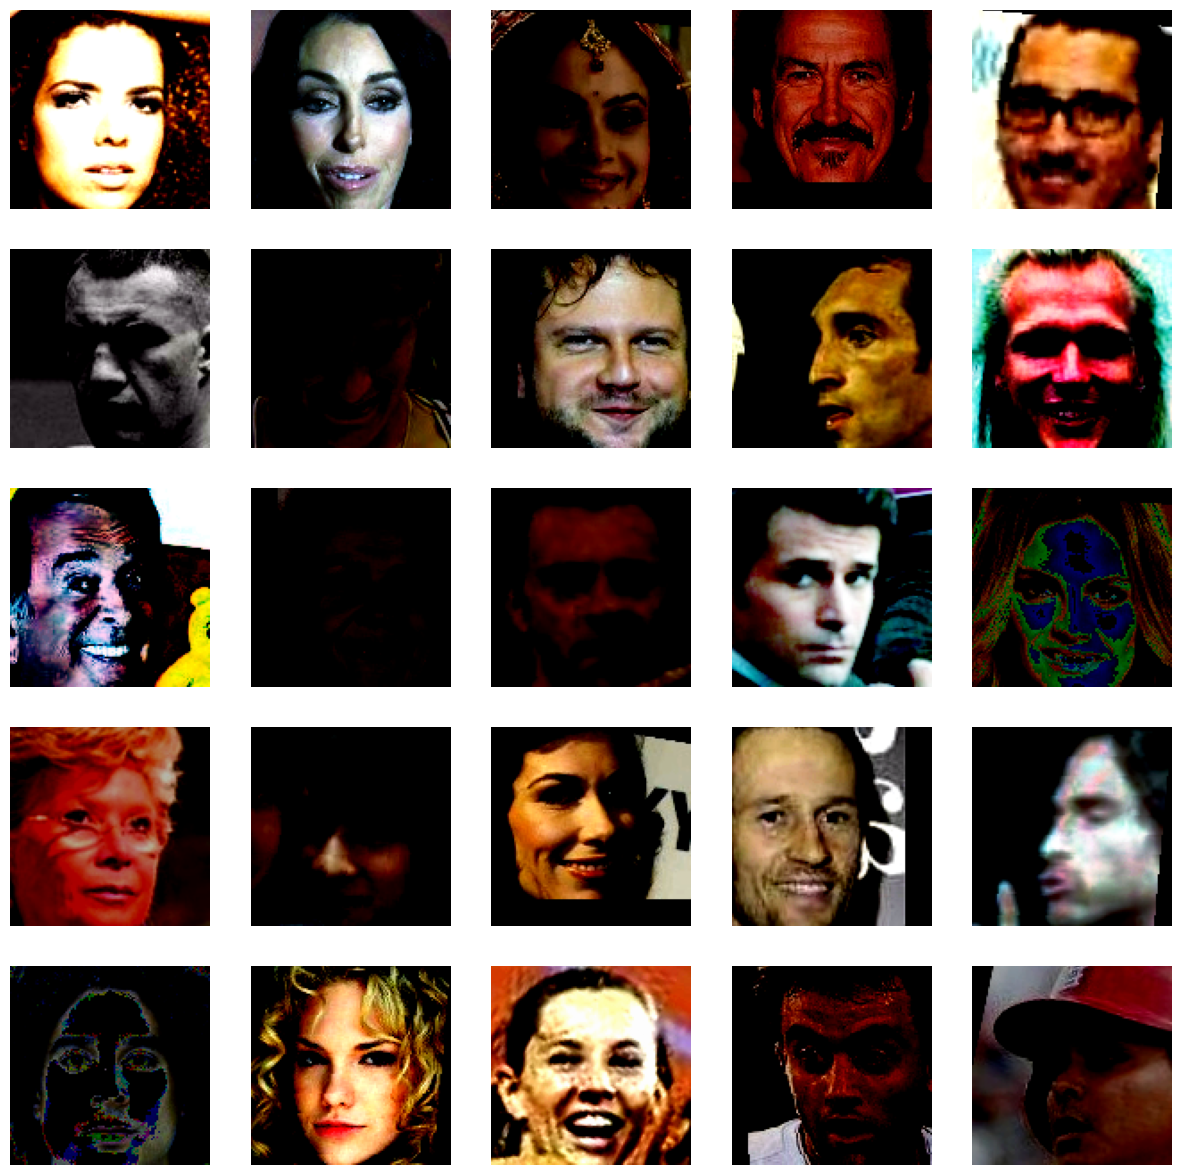

In [13]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(train_dir, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit is 18M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [ ]:
# # Residual Block for ResNet

# class ResidualBlock(torch.nn.Module):
#   expansion = 1

#   def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#     super(ResidualBlock, self).__init__()
#     self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1), torch.nn.BatchNorm2d(out_channels), torch.nn.ReLU())
#     self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1), torch.nn.BatchNorm2d(out_channels))
#     self.downsample = downsample
#     self.relu = torch.nn.ReLU()

#   def forward(self, x):
#     residual = x

#     # First convolutional layer
#     out = self.conv1(x)

#     # Second convolutional layer
#     out = self.conv2(out)

#     if self.downsample is not None:
#       residual = self.downsample(x)

#     out += residual
#     out = self.relu(out)

#     return out

In [14]:
# Residual Block for ResNet-50

class ResidualBlock(torch.nn.Module):
  expansion = 4

  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
    super(ResidualBlock, self).__init__()
    print(in_channels, out_channels)
    self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size=1), torch.nn.BatchNorm2d(out_channels), torch.nn.ReLU())
    self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1), torch.nn.BatchNorm2d(out_channels), torch.nn.ReLU())
    self.conv3 = torch.nn.Sequential(torch.nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1), torch.nn.BatchNorm2d(out_channels * self.expansion))
    self.downsample = downsample
    self.relu = torch.nn.ReLU()

  def forward(self, x):
    residual = x

    # First convolutional layer (bottleneck)
    out = self.conv1(x)

    # Second convolutional layer
    out = self.conv2(out)

    # Third convolutional layer
    out = self.conv3(out)

    if self.downsample is not None:
      residual = self.downsample(x)

    out += residual
    out = self.relu(out)

    return out

In [15]:
# ResNet Architecture stacking together blocks
class ResNet(torch.nn.Module):
  def __init__(self, block, layers, num_classes=8631):
    super(ResNet, self).__init__()
    self.in_channels = 64

    # Initial convolution and pooling layers
    self.conv1 = torch.nn.Sequential(
      torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
      torch.nn.BatchNorm2d(64),
      torch.nn.ReLU())
    self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # Residual blocks
    self.layer1 = self._make_layer(block, 64, layers[0], 1)
    self.layer2 = self._make_layer(block, 128, layers[1], 2, stride=2)
    self.layer3 = self._make_layer(block, 256, layers[2], 3, stride=2)
    self.layer4 = self._make_layer(block, 512, layers[3], 4, stride=2)

    # Average pooling and fully connected layer
    self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
    self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

  def _make_layer(self, block, out_channels, blocks, i, stride=1):
    downsample = None
    if stride != 1 or self.in_channels != out_channels * block.expansion:
      downsample = torch.nn.Sequential(
          torch.nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=
                          1, stride=stride),
          torch.nn.BatchNorm2d(out_channels * block.expansion)
      )

    layers = []
    layers.append(block(self.in_channels, out_channels, stride, downsample))
    self.in_channels = out_channels * block.expansion
    for i in range(1, blocks):
      layers.append(block(self.in_channels, out_channels))

    return torch.nn.Sequential(*layers)

  def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        feats = x
        out = self.fc(x)

        return {"feats": feats, "out": out}

model = ResNet(ResidualBlock, [3,4,6,3]).to(DEVICE)
summary(model, (3, 224, 224))

64 64
256 64
256 64
256 128
512 128
512 128
512 128
512 256
1024 256
1024 256
1024 256
1024 256
1024 256
1024 512
2048 512
2048 512
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 

In [237]:
# # Building block for ConvNeXt

# class ConvNeXtBlock(nn.Module):
#   def __init__(self, dim):
#     super(ConvNeXtBlock, self).__init__()

#     # Depthwise convolution
#     self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)

#     # Pointwise convolutions
#     self.pwconv1 = nn.Linear(dim, 4 * dim)
#     self.pwconv2 = nn.Linear(4 * dim, dim)

#     # Normalization and activation
#     self.ln = nn.LayerNorm(dim, eps=1e-6)
#     self.gelu = nn.GELU()

#   def forward(self, x):
#     input = x

#     x = self.dwconv(x)
#     x = x.permute(0, 2, 3, 1)
#     x = self.ln(x)
#     x = self.pwconv1(x)
#     x = self.gelu(x)
#     x = self.pwconv2(x)
#     x = x.permute(0, 3, 1, 2)
#     x = x + input

#     return x

In [238]:
# # Permute class

# class Permute(nn.Module):
#     def __init__(self, *dims):
#         super(Permute, self).__init__()
#         self.dims = dims

#     def forward(self, x):
#         return x.permute(*self.dims)

In [239]:
# # ConvNeXt-T architecture based on 'A ConvNet for the 2020s' (https://arxiv.org/abs/2201.03545)

# class ConvNeXt(nn.Module):
#   def __init__(self, in_channels=3, num_classes=8631, depths=[3, 3, 9, 3], dims=[96, 192, 384, 768]):
#     super(ConvNeXt, self).__init__()

#     # Downsampling layers initilization
#     self.downsampling_layers = nn.ModuleList()

#     # Stem layer
#     stem = nn.Sequential(
#         nn.Conv2d(in_channels, dims[0], kernel_size=4, stride=4),
#         Permute(0, 2, 3, 1),
#         nn.LayerNorm(dims[0], eps=1e-6),
#         Permute(0, 3, 1, 2),
#     )
#     self.downsampling_layers.append(stem)

#     # Downsampling layers
#     for i in range(3):
#       downsampling_layer = nn.Sequential(
#           Permute(0, 2, 3, 1),
#           nn.LayerNorm(dims[i], eps=1e-6),
#           Permute(0, 3, 1, 2),
#           nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2)
#       )
#       self.downsampling_layers.append(downsampling_layer)

#     # Stages
#     self.stages = nn.ModuleList()
#     for i in range(4):
#       stage = nn.Sequential(
#           *[ConvNeXtBlock(dims[i]) for _ in range(depths[i])]
#       )
#       self.stages.append(stage)

#     # Final normalization and classification head
#     self.norm = nn.LayerNorm(dims[-1], eps=1e-6)
#     self.head = nn.Linear(dims[-1], num_classes)

#   def forward(self, x):
#     for i in range(4):
#       # Downsample between stages
#       x = self.downsampling_layers[i](x)
#       x = self.stages[i](x)
#     x = x.mean([-2, -1])
#     feats = x
#     x = self.norm(x)
#     out = self.head(x)

#     return {"feats": feats, "out": out}

# model = ConvNeXt().to(DEVICE)
# summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
           Permute-2           [-1, 56, 56, 96]               0
         LayerNorm-3           [-1, 56, 56, 96]             192
           Permute-4           [-1, 96, 56, 56]               0
            Conv2d-5           [-1, 96, 56, 56]           4,800
         LayerNorm-6           [-1, 56, 56, 96]             192
            Linear-7          [-1, 56, 56, 384]          37,248
              GELU-8          [-1, 56, 56, 384]               0
            Linear-9           [-1, 56, 56, 96]          36,960
    ConvNeXtBlock-10           [-1, 96, 56, 56]               0
           Conv2d-11           [-1, 96, 56, 56]           4,800
        LayerNorm-12           [-1, 56, 56, 96]             192
           Linear-13          [-1, 56, 56, 384]          37,248
             GELU-14          [-1, 56, 

# Loss Function, Optimizer, Scheduler

In [20]:
# --------------------------------------------------- #

# Defining Loss function
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
# criterion = losses.ArcFaceLoss(num_classes=8631, embedding_size=768, margin=56, scale=64)

# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr= config['lr'])
# optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'], )
# --------------------------------------------------- #

# Defining Scheduler
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=config['factor'], patience=config['patience'])
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=config['T_0'], T_mult=['T_mult'])
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config['lr'], steps_per_epoch=len(train_loader), epochs=config['epochs'], div_factor=10, final_div_factor=1000)
scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=25, warmup_steps=5)

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

<ipython-input-20-045f91acfab0>:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


# Metrics

In [21]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [22]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [23]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# CutMix

In [24]:
import torch
import numpy as np

def cutmix_data(images, labels, alpha=1.0):
    """Applies CutMix augmentation to a batch of images and labels"""
    batch_size = images.size(0)
    indices = torch.randperm(batch_size).cuda()

    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)

    # Apply cutmix by replacing a portion of images
    images[:, :, bbx1:bbx2, bby1:bby2] = images[indices, :, bbx1:bbx2, bby1:bby2]

    labels_a = labels
    labels_b = labels[indices]

    return images, labels_a, labels_b, lam

def rand_bbox(size, lam):
    """Generate random bounding box"""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Randomly choose center
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # Calculate box coordinates
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [25]:
def cutmix_criterion(preds, labels_a, labels_b, lam):
    """Compute the CutMix loss as a weighted sum of the two."""
    return lam * criterion(preds, labels_a) + (1 - lam) * criterion(preds, labels_b)

# Train and Validation Function

In [26]:
# CUTMIX
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):
    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):
        optimizer.zero_grad()

        # send to cuda
        images = images.to(device)
        labels = labels.to(device)

        # Apply CutMix
        if np.random.rand() < config.get('cutmix_prob', 0.5):
            images, labels_a, labels_b, lam = cutmix_data(images, labels)
        else:
            labels_a, labels_b, lam = labels, labels, 1.0

        # Forward pass with mixed precision
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = cutmix_criterion(outputs['out'], labels_a, labels_b, lam)

        # Backward pass with mixed precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update metrics
        loss_m.update(loss.item())
        acc = accuracy(outputs['out'], labels)[0].item()
        acc_m.update(acc)

        batch_bar.set_postfix(acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg), loss="{:.04f} ({:.04f})".format(loss.item(), loss_m.avg), lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        batch_bar.update()

    lr_scheduler.step()
    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [305]:
print(criterion)

CrossEntropyLoss()


In [ ]:
# # Normal
# def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

#     model.train()

#     # metric meters
#     loss_m = AverageMeter()
#     acc_m = AverageMeter()

#     # Progress Bar
#     batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

#     for i, (images, labels) in enumerate(dataloader):

#         optimizer.zero_grad() # Zero gradients

#         # send to cuda
#         images = images.to(device, non_blocking=True)
#         if isinstance(labels, (tuple, list)):
#             targets1, targets2, lam = labels
#             labels = (targets1.to(device), targets2.to(device), lam)
#         else:
#             labels = labels.to(device, non_blocking=True)

#         # forward
#         with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
#             outputs = model(images)

#             # Use the type of output depending on the loss function you want to use
#             loss = criterion(outputs['out'], labels)

#         scaler.scale(loss).backward() # This is a replacement for loss.backward()
#         scaler.step(optimizer) # This is a replacement for optimizer.step()
#         scaler.update()
#         # metrics
#         loss_m.update(loss.item())
#         if 'feats' in outputs:
#             acc = accuracy(outputs['out'], labels)[0].item()
#         else:
#             acc = 0.0
#         acc_m.update(acc)

#         # You may want to call some schedulers inside the train function. What are these?
#         # if lr_scheduler is not None:
#         #     lr_scheduler.step()

#         # tqdm lets you add some details so you can monitor training as you train.
#         batch_bar.set_postfix(
#             # acc         = "{:.04f}%".format(100*accuracy),
#             acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
#             loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
#             lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

#         batch_bar.update() # Update tqdm bar

#     # You may want to call some schedulers inside the train function. What are these?
#     if lr_scheduler is not None:
#         lr_scheduler.step()

#     batch_bar.close()

#     return acc_m.avg, loss_m.avg

In [318]:
# # ArcFace
# import torch.nn.functional as F

# def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

#     model.train()

#     # metric meters
#     loss_m = AverageMeter()
#     acc_m = AverageMeter()

#     # Progress Bar
#     batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

#     for i, (images, labels) in enumerate(dataloader):

#         optimizer.zero_grad()  # Zero gradients

#         # Send to cuda
#         images = images.to(device, non_blocking=True)
#         if isinstance(labels, (tuple, list)):
#             targets1, targets2, lam = labels
#             labels = (targets1.to(device), targets2.to(device), lam)
#         else:
#             labels = labels.to(device, non_blocking=True)

#         # Forward pass
#         with torch.cuda.amp.autocast():
#             outputs = model(images)

#             # L2 normalization of embeddings
#             normalized_feats = F.normalize(outputs['feats'], p=2, dim=1)
#             with torch.no_grad():
#                 criterion.W.data = F.normalize(criterion.W.data, p=2, dim=1)

#             # Use normalized feats for ArcFace loss
#             loss = criterion(normalized_feats, labels)

#         scaler.scale(loss).backward()  # This is a replacement for loss.backward()
#         scaler.step(optimizer)  # This is a replacement for optimizer.step()
#         scaler.update()

#         # Update metrics
#         loss_m.update(loss.item())
#         if 'feats' in outputs:
#             acc = accuracy(outputs['out'], labels)[0].item()
#         else:
#             acc = 0.0
#         acc_m.update(acc)

#         # TQDM progress bar update
#         batch_bar.set_postfix(
#             acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
#             loss="{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
#             lr="{:.04f}".format(float(optimizer.param_groups[0]['lr']))
#         )

#         batch_bar.update()  # Update tqdm bar

#     # Scheduler step
#     if lr_scheduler is not None:
#         lr_scheduler.step()

#     batch_bar.close()
#     return acc_m.avg, loss_m.avg

In [321]:
print(criterion)

ArcFaceLoss(
  (distance): CosineSimilarity()
  (reducer): MeanReducer()
  (cross_entropy): CrossEntropyLoss()
)


In [28]:
# Normal
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs['out'], labels)

        # metrics
        acc = accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [29]:
# # ArcFace
# @torch.no_grad()
# def valid_epoch_cls(model, dataloader, device, config):

#     model.eval()
#     batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

#     # Metric meters
#     loss_m = AverageMeter()
#     acc_m = AverageMeter()

#     for i, (images, labels) in enumerate(dataloader):

#         # Move images to device
#         images, labels = images.to(device), labels.to(device)

#         # Forward pass
#         with torch.inference_mode():
#             outputs = model(images)

#             # L2 normalization of embeddings and arcface weights
#             normalized_feats = F.normalize(outputs['feats'], p=2, dim=1)
#             criterion.W.data = F.normalize(criterion.W.data, p=2, dim=1)

#             # Use normalized feats for ArcFace loss
#             loss = criterion(normalized_feats, labels)

#         # Compute accuracy
#         acc = accuracy(outputs['out'], labels)[0].item()
#         loss_m.update(loss.item())
#         acc_m.update(acc)

#         batch_bar.set_postfix(
#             acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
#             loss="{:.04f} ({:.04f})".format(loss.item(), loss_m.avg)
#         )

#         batch_bar.update()

#     batch_bar.close()
#     return acc_m.avg, loss_m.avg

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Verification Task

In [30]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC'], metric_dict['EER']

# WandB

In [31]:
wandb.login(key="4c68592a14802648ff3220711294d6e5fe7d272f") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [32]:
# Create your wandb run
run = wandb.init(
    name = config['run_name'], ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # id = gen_id, ### Insert specific run id here if you want to resume a previous run
    # resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config, ### Wandb Config for your run
)

wandb: Currently logged in as: jordantab20 (jordantab20-carnegie-mellon-university). Use `wandb login --relogin` to force relogin


# Checkpointing and Loading Model

In [33]:
# Uncomment the line for saving the scheduler save dict if you are using a scheduler
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

In [34]:
print(os.path.exists("best_cls.pth"))

False


# Load Pre-Trained Model

In [309]:
# from pytorch_metric_learning import losses
model, optimizer, scheduler, epoch, metrics = load_model(model, optimizer, scheduler, "best_cls (6).pth")

<ipython-input-308-917ec4f96c61>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


In [310]:
criterion = losses.ArcFaceLoss(num_classes=8631, embedding_size=768, margin=28.6, scale=64)
optimizer = torch.optim.SGD(list(model.parameters()) + list(criterion.parameters()), lr=config['lr'])
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config['lr'], steps_per_epoch=len(train_loader), epochs=config['epochs'], div_factor=10, final_div_factor=1000)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

In [311]:
print(scheduler.state_dict())

{'T_max': 20, 'eta_min': 0, 'base_lrs': [0.001], 'last_epoch': 0, 'verbose': False, '_step_count': 1, '_get_lr_called_within_step': False, '_last_lr': [0.001]}


# Experiments

In [ ]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

        # train
        train_cls_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics = {
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        }
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, val_loader, DEVICE, config)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })
            # scheduler.step(valid_cls_acc)x

        # retrieval validation
        valid_ret_acc, valid_eer = valid_epoch_ver(model, pair_dataloader, DEVICE, config)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc,
            'valid_eer': valid_eer,
            'lr': curr_lr
        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")

        # log to tracker
        if run is not None:
            run.log(metrics)


Epoch 1/30



Epoch 1/30: 
Train Cls. Acc 0.0114%	 Train Cls. Loss 9.1862	 Learning Rate 0.0208


Val Cls. Acc 0.0069%	 Val Cls. Loss 9.1090


{'ACC': 57.0, 'EER': 44.00785854610659, 'AUC': 58.01179582184628, 'TPRs': [('TPR@FPR=1e-4', 0.6109979633401221), ('TPR@FPR=5e-4', 0.6109979633401221), ('TPR@FPR=1e-3', 0.6109979633401221), ('TPR@FPR=5e-3', 1.6293279022403258), ('TPR@FPR=5e-2', 8.146639511201629)]}
Val Ret. Acc 57.0000%
Saved epoch model


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Saved best classification model
Saved best retrieval model

Epoch 2/30



Epoch 2/30: 
Train Cls. Acc 0.0118%	 Train Cls. Loss 9.0904	 Learning Rate 0.0406


Val Cls. Acc 0.0162%	 Val Cls. Loss 9.0547


{'ACC': 54.8, 'EER': 46.639511201629766, 'AUC': 54.690119598749995, 'TPRs': [('TPR@FPR=1e-4', 1.8329938900203666), ('TPR@FPR=5e-4', 1.8329938900203666), ('TPR@FPR=1e-3', 1.8329938900203666), ('TPR@FPR=5e-3', 4.0733197556008145), ('TPR@FPR=5e-2', 12.219959266802444)]}
Val Ret. Acc 54.8000%
Saved epoch model
Saved best classification model

Epoch 3/30



Epoch 3/30: 
Train Cls. Acc 0.0215%	 Train Cls. Loss 9.0172	 Learning Rate 0.0604


Val Cls. Acc 0.0231%	 Val Cls. Loss 9.0697


{'ACC': 56.3, 'EER': 45.1866404715472, 'AUC': 57.28656084571401, 'TPRs': [('TPR@FPR=1e-4', 1.6293279022403258), ('TPR@FPR=5e-4', 1.6293279022403258), ('TPR@FPR=1e-3', 1.6293279022403258), ('TPR@FPR=5e-3', 3.2586558044806515), ('TPR@FPR=5e-2', 11.405295315682281)]}
Val Ret. Acc 56.3000%
Saved epoch model
Saved best classification model

Epoch 4/30



Epoch 4/30: 
Train Cls. Acc 0.0695%	 Train Cls. Loss 8.7230	 Learning Rate 0.0802


Val Cls. Acc 0.0625%	 Val Cls. Loss 8.8692


{'ACC': 68.0, 'EER': 32.79022403256684, 'AUC': 72.96364021943111, 'TPRs': [('TPR@FPR=1e-4', 2.0366598778004072), ('TPR@FPR=5e-4', 2.0366598778004072), ('TPR@FPR=1e-3', 2.0366598778004072), ('TPR@FPR=5e-3', 5.091649694501019), ('TPR@FPR=5e-2', 17.515274949083505)]}
Val Ret. Acc 68.0000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 5/30



Epoch 5/30: 
Train Cls. Acc 0.4055%	 Train Cls. Loss 8.1759	 Learning Rate 0.1000


Val Cls. Acc 0.1227%	 Val Cls. Loss 8.7311


{'ACC': 74.1, 'EER': 26.883910386965397, 'AUC': 81.0878724706805, 'TPRs': [('TPR@FPR=1e-4', 3.054989816700611), ('TPR@FPR=5e-4', 3.054989816700611), ('TPR@FPR=1e-3', 3.054989816700611), ('TPR@FPR=5e-3', 15.478615071283095), ('TPR@FPR=5e-2', 35.437881873727086)]}
Val Ret. Acc 74.1000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 6/30



Epoch 6/30: 
Train Cls. Acc 1.9688%	 Train Cls. Loss 7.5710	 Learning Rate 0.0994


Val Cls. Acc 0.0764%	 Val Cls. Loss 9.2723


{'ACC': 69.4, 'EER': 30.957230142566278, 'AUC': 75.05551798782805, 'TPRs': [('TPR@FPR=1e-4', 7.942973523421588), ('TPR@FPR=5e-4', 7.942973523421588), ('TPR@FPR=1e-3', 7.942973523421588), ('TPR@FPR=5e-3', 10.590631364562118), ('TPR@FPR=5e-2', 31.975560081466398)]}
Val Ret. Acc 69.4000%
Saved epoch model

Epoch 7/30



Epoch 7/30: 
Train Cls. Acc 5.8369%	 Train Cls. Loss 6.9821	 Learning Rate 0.0976


Val Cls. Acc 0.1690%	 Val Cls. Loss 8.8564


{'ACC': 78.3, 'EER': 22.40325865580449, 'AUC': 86.02587238265198, 'TPRs': [('TPR@FPR=1e-4', 11.201629327902241), ('TPR@FPR=5e-4', 11.201629327902241), ('TPR@FPR=1e-3', 11.201629327902241), ('TPR@FPR=5e-3', 19.551934826883908), ('TPR@FPR=5e-2', 49.69450101832994)]}
Val Ret. Acc 78.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 8/30



Epoch 8/30: 
Train Cls. Acc 11.9986%	 Train Cls. Loss 6.4011	 Learning Rate 0.0946


Val Cls. Acc 0.1389%	 Val Cls. Loss 9.0725


{'ACC': 86.3, 'EER': 13.948919450004452, 'AUC': 93.75077525118138, 'TPRs': [('TPR@FPR=1e-4', 36.65987780040733), ('TPR@FPR=5e-4', 36.65987780040733), ('TPR@FPR=1e-3', 36.65987780040733), ('TPR@FPR=5e-3', 43.17718940936864), ('TPR@FPR=5e-2', 74.33808553971487)]}
Val Ret. Acc 86.3000%
Saved epoch model
Saved best retrieval model

Epoch 9/30



Epoch 9/30: 
Train Cls. Acc 18.7949%	 Train Cls. Loss 5.9562	 Learning Rate 0.0905


Val Cls. Acc 0.1921%	 Val Cls. Loss 8.9374


{'ACC': 85.2, 'EER': 15.274949083503051, 'AUC': 92.55198684373737, 'TPRs': [('TPR@FPR=1e-4', 17.10794297352342), ('TPR@FPR=5e-4', 17.10794297352342), ('TPR@FPR=1e-3', 17.10794297352342), ('TPR@FPR=5e-3', 22.810590631364562), ('TPR@FPR=5e-2', 66.39511201629328)]}
Val Ret. Acc 85.2000%
Saved epoch model
Saved best classification model

Epoch 10/30



Epoch 10/30: 
Train Cls. Acc 25.5942%	 Train Cls. Loss 5.6048	 Learning Rate 0.0855


Val Cls. Acc 0.2275%	 Val Cls. Loss 8.8877


{'ACC': 85.3, 'EER': 15.885947046843196, 'AUC': 92.72244207123109, 'TPRs': [('TPR@FPR=1e-4', 8.55397148676171), ('TPR@FPR=5e-4', 8.55397148676171), ('TPR@FPR=1e-3', 8.55397148676171), ('TPR@FPR=5e-3', 21.9959266802444), ('TPR@FPR=5e-2', 68.83910386965377)]}
Val Ret. Acc 85.3000%
Saved epoch model
Saved best classification model

Epoch 11/30



Epoch 11/30: 
Train Cls. Acc 31.2904%	 Train Cls. Loss 5.2661	 Learning Rate 0.0796


Val Cls. Acc 0.1574%	 Val Cls. Loss 9.0062


{'ACC': 91.4, 'EER': 9.430255402815694, 'AUC': 96.64771385929039, 'TPRs': [('TPR@FPR=1e-4', 50.30549898167006), ('TPR@FPR=5e-4', 50.30549898167006), ('TPR@FPR=1e-3', 50.30549898167006), ('TPR@FPR=5e-3', 56.82281059063137), ('TPR@FPR=5e-2', 87.16904276985743)]}
Val Ret. Acc 91.4000%
Saved epoch model
Saved best retrieval model

Epoch 12/30



Epoch 12/30: 
Train Cls. Acc 36.9031%	 Train Cls. Loss 4.9459	 Learning Rate 0.0730


Val Cls. Acc 0.3449%	 Val Cls. Loss 8.7462


{'ACC': 90.3, 'EER': 10.18329938900218, 'AUC': 96.59449661690387, 'TPRs': [('TPR@FPR=1e-4', 49.89816700610998), ('TPR@FPR=5e-4', 49.89816700610998), ('TPR@FPR=1e-3', 49.89816700610998), ('TPR@FPR=5e-3', 57.841140529531565), ('TPR@FPR=5e-2', 82.68839103869654)]}
Val Ret. Acc 90.3000%
Saved epoch model
Saved best classification model

Epoch 13/30



Epoch 13/30: 
Train Cls. Acc 42.0203%	 Train Cls. Loss 4.7005	 Learning Rate 0.0658


Val Cls. Acc 0.3611%	 Val Cls. Loss 8.7299


{'ACC': 91.7, 'EER': 8.757637474541779, 'AUC': 97.05984739055454, 'TPRs': [('TPR@FPR=1e-4', 32.382892057026474), ('TPR@FPR=5e-4', 32.382892057026474), ('TPR@FPR=1e-3', 32.382892057026474), ('TPR@FPR=5e-3', 53.76782077393075), ('TPR@FPR=5e-2', 87.78004073319755)]}
Val Ret. Acc 91.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 14/30



Epoch 14/30: 
Train Cls. Acc 45.4659%	 Train Cls. Loss 4.4811	 Learning Rate 0.0582


Val Cls. Acc 0.3519%	 Val Cls. Loss 8.6036


{'ACC': 93.9, 'EER': 6.313645621162407, 'AUC': 97.83929993317835, 'TPRs': [('TPR@FPR=1e-4', 45.621181262729124), ('TPR@FPR=5e-4', 45.621181262729124), ('TPR@FPR=1e-3', 45.621181262729124), ('TPR@FPR=5e-3', 73.11608961303462), ('TPR@FPR=5e-2', 92.4643584521385)]}
Val Ret. Acc 93.9000%
Saved epoch model
Saved best retrieval model

Epoch 15/30


Train:  89%|████████▉ | 1775/1998 [03:32<00:18, 11.79it/s, acc=71.2963% (48.1912), loss=4.7440 (4.3515), lr=0.0582]

# Testing and Kaggle Submission (Verification)

In [ ]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [ ]:
scores = test_epoch_ver(model, test_pair_dataloader, config)

In [ ]:
with open("submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [ ]:
### Finish your wandb run
run.finish()

lr,▁▄█
train_cls_acc,▁▅█
train_loss,█▅▁
valid_cls_acc,▁▁▁
valid_eer,▁▁▁
valid_loss,█▄▁
valid_ret_acc,▁▁▁
lr,4e-05
train_cls_acc,99.99513
train_loss,63.40049
valid_cls_acc,92.53264


In [ ]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-hw-2-p-2-face-verification-fall-2024 -f ./submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle

100% 139k/139k [00:00<00:00, 364kB/s]
Successfully submitted to 11785 HW2P2 Face Verification Fall 2024

In [ ]:
from google.colab import runtime
runtime.unassign()